 #  <div style="text-align: center">  Kaggle : Santander Customer Transaction Prediction  </div> 
###  <div style="text-align: center">Can you identify who will make a transaction? </div> 
<img src='https://ichef.bbci.co.uk/news/660/cpsprodpb/144B7/production/_104872138_santander2.jpg'>

### <div style="text-align:center"> Kernel By: <b> Kamal Chouhbi</b></div>


 <a id="top"></a> <br>
## Notebook  Content
1. [Introduction](#1)
1. [Load packages](#2)
    1. [import](21)
    1. [Setup](22)
    1. [Version](23)
1. [Problem Definition](#3)
    1. [Problem Feature](#31)
    1. [Aim](#32)
    1. [Variables](#33)
    1. [Evaluation](#34)
1. [Exploratory Data Analysis(EDA)](#4)
    1. [Data Collection](#41)
    1. [Visualization](#42)
    1. [Data Preprocessing](#43)
1. [Machine Learning Explainability for Santander](#5)
    1. [Permutation Importance](#51)
    1. [How to calculate and show importances?](#52)
    1. [What can be inferred from the above?](#53)
    1. [Partial Dependence Plots](#54)
1. [Model Development](#6)
    1. [lightgbm](#61)
    1. [RandomForestClassifier](#62)
    1. [DecisionTreeClassifier](#63)
    1. [CatBoostClassifier](#64)
    1. [Funny Combine](#65)
1. [References](#7)

 <a id="1"></a> <br>
## 1- Introduction
At [Santander](https://www.santanderbank.com) their mission is to help people and businesses prosper. they are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.
<img src='https://www.smava.de/kredit/wp-content/uploads/2015/12/santander-bank.png' width=400 height=400>

In this kernel we are going to create a **Machine Learning Explainability** for **Santander** based this perfect [course](https://www.kaggle.com/learn/machine-learning-explainability) in kaggle.

 <a id="2"></a> <br>
 ## 2- Load packages
  <a id="21"></a> <br>
## 2-1 Import

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier,Pool
from IPython.display import display
import matplotlib.patches as patch
import matplotlib.pyplot as plt
from sklearn.svm import NuSVR
from scipy.stats import norm
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import time
import glob
import sys
import os
import gc

 <a id="22"></a> <br>
##  2-2 Setup

In [3]:
# for get better result chage fold_n to 5
fold_n=5
folds = StratifiedKFold(n_splits=fold_n, shuffle=True, random_state=10)
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 15)

 <a id="23"></a> <br>
## 2-3 Version


In [4]:
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('Python: {}'.format(sys.version))

pandas: 0.24.2
numpy: 1.16.2
Python: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


<a id="3"></a> 
<br>
## 3- Problem Definition
In this **challenge**, we should help this **bank**  identify which **customers** will make a **specific transaction** in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this **problem**.


<a id="31"></a> 
### 3-1 Problem Feature

1. train.csv - the training set.
1. test.csv - the test set. The test set contains some rows which are not included in scoring.
1. sample_submission.csv - a sample submission file in the correct format.


<a id="32"></a> 
### 3-2 Aim
In this competition, The task is to predict the value of **target** column in the test set.

<a id="33"></a> 
### 3-3 Variables

We are provided with an **anonymized dataset containing numeric feature variables**, the binary **target** column, and a string **ID_code** column.

The task is to predict the value of **target column** in the test set.

<a id="34"></a> 
## 3-4 evaluation
**Submissions** are evaluated on area under the [ROC curve](http://en.wikipedia.org/wiki/Receiver_operating_characteristic) between the predicted probability and the observed target.
<img src='https://upload.wikimedia.org/wikipedia/commons/6/6b/Roccurves.png' width=300 height=300>

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve

<a id="4"></a> 
## 4- Exploratory Data Analysis(EDA)
 In this section, we'll analysis how to use graphical and numerical techniques to begin uncovering the structure of your data. 
*  Data Collection
*  Visualization
*  Data Preprocessing
*  Data Cleaning
<img src="https://miro.medium.com/max/1130/1*3sr-fMg4S_yEncGsIjyG9A.png" width=400 height=400>

 <a id="41"></a> <br>
## 4-1 Data Collection

In [6]:
# import train & test Datasets
train= pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [7]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [10]:
train.shape, test.shape, sample_submission.shape

((200000, 202), (200000, 201), (200000, 2))

In [11]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.925500000000000,-6.7863,11.908099999999999,5.093000000000000,11.460699999999999,-9.2834,5.1187,18.626600000000000,...,4.4354,3.9642,3.1364,1.691000000000000,18.522700000000000,-2.3978,7.8784,8.563499999999999,12.780300000000000,-1.091400000000000
1,train_1,0,11.500600000000000,-4.1473,13.858800000000000,5.388999999999999,12.362200000000000,7.0433,5.6208,16.533799999999999,...,7.6421,7.7214,2.5837,10.951599999999999,15.430500000000000,2.0339,8.1267,8.788900000000000,18.355999999999998,1.951800000000000
2,train_2,0,8.609299999999999,-2.7457,12.080500000000001,7.892800000000000,10.582500000000000,-9.0837,6.9427,14.615500000000001,...,2.9057,9.7905,1.6704,1.685800000000000,21.604199999999999,3.1417,-6.5213,8.267500000000000,14.722200000000001,0.396500000000000
3,train_3,0,11.060400000000000,-2.1518,8.952199999999999,7.195700000000000,12.584600000000000,-1.8361,5.8428,14.925000000000001,...,4.4666,4.7433,0.7178,1.421400000000000,23.034700000000001,-1.2706,-2.9275,10.292199999999999,17.969700000000000,-8.999599999999999
4,train_4,0,9.836900000000000,-1.4834,12.874599999999999,6.637500000000000,12.277200000000001,2.4486,5.9405,19.251400000000000,...,-1.4905,9.5214,-0.1508,9.194200000000000,13.287599999999999,-1.5121,3.9267,9.503100000000000,17.997399999999999,-8.810400000000000


In [28]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,...,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000
mean,0.100490000000000,10.679972648620605,-1.627627611160278,10.715126037597656,6.796522617340088,11.078254699707031,-5.065340042114258,5.408960819244385,16.545988082885742,0.284159243106842,...,3.234436273574829,7.438448905944824,1.927832603454590,3.331773042678833,17.993810653686523,-0.142086714506149,2.303354501724243,8.908224105834961,15.870863914489746,-3.326541900634766
std,0.300652975806093,3.039989709854126,4.049966812133789,2.640832424163818,2.043276309967041,1.623113632202148,7.863115310668945,0.866584956645966,3.418008565902710,3.332575798034668,...,4.559854030609131,3.023208379745483,1.478387713432312,3.991934061050415,3.135113477706909,1.429340600967407,5.454273700714111,0.921603024005890,3.010892391204834,10.437831878662109
min,0.000000000000000,0.408399999141693,-15.043399810791016,2.117100000381470,-0.040199998766184,5.074800014495850,-32.562599182128906,2.347300052642822,5.349699974060059,-10.505499839782715,...,-14.093299865722656,-2.691699981689453,-3.814500093460083,-11.783399581909180,8.694399833679199,-5.261000156402588,-14.209600448608398,5.960599899291992,6.299300193786621,-38.852798461914062
25%,0.000000000000000,8.453850269317627,-4.740024805068970,8.722474813461304,5.254074931144714,9.883174657821655,-11.200350046157837,4.767700195312500,13.943799972534180,-2.317800045013428,...,-0.058825000189245,5.157400131225586,0.889775007963181,0.584599971771240,15.629799842834473,-1.170699954032898,-1.946925014257431,8.252799987792969,13.829700469970703,-11.208474636077881
50%,0.000000000000000,10.524750232696533,-1.608050048351288,10.579999923706055,6.824999809265137,11.108250141143799,-4.833149909973145,5.385099887847900,16.456800460815430,0.393700003623962,...,3.203599929809570,7.347749948501587,1.901299953460693,3.396350026130676,17.957949638366699,-0.172700002789497,2.408900022506714,8.888199806213379,15.934050083160400,-2.819550037384033
75%,0.000000000000000,12.758199691772461,1.358625024557114,12.516699790954590,8.324099540710449,12.261124849319458,0.924799978733063,6.002999782562256,19.102899551391602,2.937900066375732,...,6.406199932098389,9.512524843215942,2.949500083923340,6.205800056457520,20.396524906158447,0.829599976539612,6.556725144386292,9.593299865722656,18.064724445343018,4.836800098419189
max,1.000000000000000,20.315000534057617,10.376799583435059,19.353000640869141,13.188300132751465,16.671400070190430,17.251600265502930,8.447699546813965,27.691799163818359,10.151300430297852,...,18.440900802612305,16.716499328613281,8.402400016784668,18.281799316406250,27.928800582885742,4.272900104522705,18.321500778198242,12.000399589538574,26.079099655151367,28.500699996948242


I noticed the size of the properties dataset is pretty big for a lower/mid-range laptop so I decided to make the dataset smaller without losing information.
It is important to verify first the different ranges for each variable in the dataset. Check ranges <a href="https://clickhouse-docs.readthedocs.io/en/latest/data_types/int_uint.html">here</a>

# Reducing  memory size by ~50%
Because we make a lot of calculations in this kernel, we'd better reduce the size of the data.
1. 300 MB before Reducing
1. 150 MB after Reducing

It uses the following approach:
- Iterate over every column
- Determine if the column is numeric
- Determine if the column can be represented by an integer
- Find the min and the max value
- Determine and apply the smallest datatype that can fit the range of values

In [8]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

Reducing for train data set

In [9]:
train, NAlist = reduce_mem_usage(train)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 308.2276153564453  MB
******************************
Column:  target
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  var_0
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_1
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_2
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_3
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_4
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_5
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_6
dtype before:  float64
dtype after:  fl

dtype after:  float32
******************************
******************************
Column:  var_67
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_68
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_69
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_70
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_71
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_72
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_73
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_74
dtype before:  float64
dtype after:  fl

dtype after:  float32
******************************
******************************
Column:  var_135
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_136
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_137
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_138
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_139
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_140
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_141
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_142
dtype before:  float64
dtype af

Reducing for test data set

In [10]:
test, NAlist = reduce_mem_usage(test)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 306.7017364501953  MB
******************************
Column:  var_0
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_1
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_2
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_3
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_4
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_5
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_6
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_7
dtype before:  float64
dtype after: 

dtype after:  float32
******************************
******************************
Column:  var_67
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_68
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_69
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_70
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_71
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_72
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_73
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_74
dtype before:  float64
dtype after:  fl

dtype after:  float32
******************************
******************************
Column:  var_134
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_135
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_136
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_137
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_138
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_139
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_140
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_141
dtype before:  float64
dtype af

 <a id="41"></a> <br>
##   4-1-1Data set fields

In [30]:
train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [31]:
print(len(train.columns))

202


In [32]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float32(200), object(1), uint8(1)
memory usage: 154.3+ MB
None


 <a id="422"></a> <br>
## 4-2-2 numerical values Describe

In [33]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,...,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000
mean,0.100490000000000,10.679972648620605,-1.627627611160278,10.715126037597656,6.796522617340088,11.078254699707031,-5.065340042114258,5.408960819244385,16.545988082885742,0.284159243106842,...,3.234436273574829,7.438448905944824,1.927832603454590,3.331773042678833,17.993810653686523,-0.142086714506149,2.303354501724243,8.908224105834961,15.870863914489746,-3.326541900634766
std,0.300652975806093,3.039989709854126,4.049966812133789,2.640832424163818,2.043276309967041,1.623113632202148,7.863115310668945,0.866584956645966,3.418008565902710,3.332575798034668,...,4.559854030609131,3.023208379745483,1.478387713432312,3.991934061050415,3.135113477706909,1.429340600967407,5.454273700714111,0.921603024005890,3.010892391204834,10.437831878662109
min,0.000000000000000,0.408399999141693,-15.043399810791016,2.117100000381470,-0.040199998766184,5.074800014495850,-32.562599182128906,2.347300052642822,5.349699974060059,-10.505499839782715,...,-14.093299865722656,-2.691699981689453,-3.814500093460083,-11.783399581909180,8.694399833679199,-5.261000156402588,-14.209600448608398,5.960599899291992,6.299300193786621,-38.852798461914062
25%,0.000000000000000,8.453850269317627,-4.740024805068970,8.722474813461304,5.254074931144714,9.883174657821655,-11.200350046157837,4.767700195312500,13.943799972534180,-2.317800045013428,...,-0.058825000189245,5.157400131225586,0.889775007963181,0.584599971771240,15.629799842834473,-1.170699954032898,-1.946925014257431,8.252799987792969,13.829700469970703,-11.208474636077881
50%,0.000000000000000,10.524750232696533,-1.608050048351288,10.579999923706055,6.824999809265137,11.108250141143799,-4.833149909973145,5.385099887847900,16.456800460815430,0.393700003623962,...,3.203599929809570,7.347749948501587,1.901299953460693,3.396350026130676,17.957949638366699,-0.172700002789497,2.408900022506714,8.888199806213379,15.934050083160400,-2.819550037384033
75%,0.000000000000000,12.758199691772461,1.358625024557114,12.516699790954590,8.324099540710449,12.261124849319458,0.924799978733063,6.002999782562256,19.102899551391602,2.937900066375732,...,6.406199932098389,9.512524843215942,2.949500083923340,6.205800056457520,20.396524906158447,0.829599976539612,6.556725144386292,9.593299865722656,18.064724445343018,4.836800098419189
max,1.000000000000000,20.315000534057617,10.376799583435059,19.353000640869141,13.188300132751465,16.671400070190430,17.251600265502930,8.447699546813965,27.691799163818359,10.151300430297852,...,18.440900802612305,16.716499328613281,8.402400016784668,18.281799316406250,27.928800582885742,4.272900104522705,18.321500778198242,12.000399589538574,26.079099655151367,28.500699996948242


 <a id="42"></a> <br>
## 4-2 Visualization

<a id="421"></a> 
## 4-2-1 hist

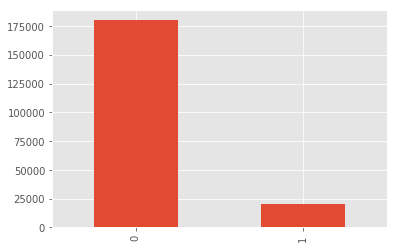

In [11]:
train['target'].value_counts().plot.bar();

 <a id="422"></a> <br>
## 4-2-2 Frequency

#### Mean Frequency

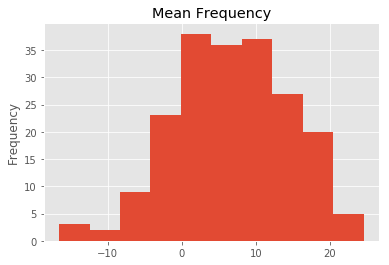

In [36]:
train[train.columns[2:]].mean().plot('hist');plt.title('Mean Frequency');

#### The frequency distribution of var_0

In [43]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return np.concatenate([x[0:N-1], (cumsum[N:] - cumsum[:-N]) / N])

var = 'var_0' #feat we are going to analyse
mydf = train.copy() #df we are going to analyze

def df_to_bin(var, mydf):
    IQR = mydf[var].quantile([0.75]).values - mydf[var].quantile([0.25]).values #inter-quartile range
    n = 200000 #size of our dataframe
    bin_size = 2.5*IQR/n**(1/3) #Freedman-Diaconis rule to define the bin size
    bin_number = int((mydf[var].max() - mydf[var].min())/bin_size)

    #creat new feature based on the bins
    mydf['new' + var] = pd.cut(mydf[var], bins = bin_number, labels = range(bin_number)).astype('float')

    #separate dfs betweens target ==0 and target == 1
    df_no_transfer = mydf['new' + var][mydf['target'] == 0].value_counts().sort_index()
    #get the bin frequency height (H) and the index of that bin (X)
    H0,X0 = list(df_no_transfer.values), list(df_no_transfer.index) 

    df_with_transfer = mydf['new' + var][mydf['target'] == 1].value_counts().sort_index()
    H1,X1 = list(df_with_transfer.values), list(df_with_transfer.index) 

    #If there are any bins with 0 frequency between 0 and the total number of bins, lets put it in our list
    for i in range(bin_number):
        if i not in X0:
            H0.append(0)
            X0.append(i)

        if i not in X1:
            H1.append(0)
            X1.append(i)

    #sort the bins so the list index == bin number
    H0 = [h for _,h in sorted(zip(X0,H0))]
    X0 = [x for x,_ in sorted(zip(X0,H0))]
    H1 = [h for _,h in sorted(zip(X1,H1))]
    X1 = [x for x,_ in sorted(zip(X1,H1))]

    H0 = running_mean(H0, 2)  
    H1 = running_mean(H1, 2)  
    Hsum = H0 + H1
    
    return bin_size, bin_number, mydf, H0, H1, Hsum, X0, X1

var = 'var_0'
bin_size, bin_number, mydf, H0, H1, Hsum, X0, X1 = df_to_bin(var, train)

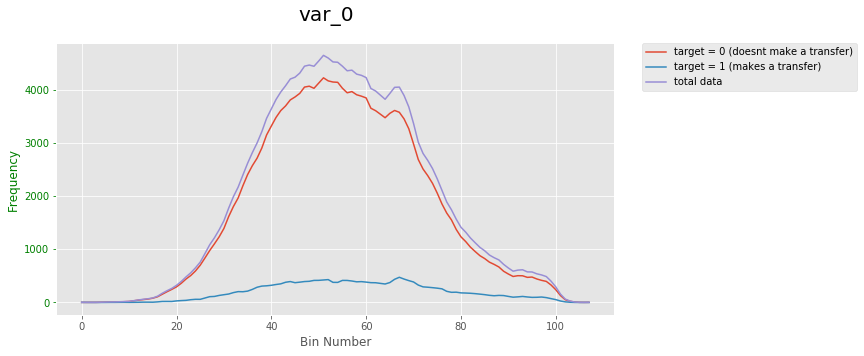

In [47]:
#plot the result
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(H0, label='target = 0 (doesnt make a transfer)')
ax1.plot(H1, label='target = 1 (makes a transfer)')
ax1.plot(Hsum, label='total data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.suptitle(var, fontsize=20)
ax1.set_ylabel('Frequency', color='g', fontsize=12)
ax1.tick_params(axis='y', colors='green')
plt.xlabel('Bin Number', fontsize=12)
plt.show()

- In blue you can see the distribution of the clients that make a transfer.
- In red it is the distribution of the clients that do not make a transfer.
- And finally, in purple, it is the total distribution

<a id="423"></a> 
## 4-2-3 countplot

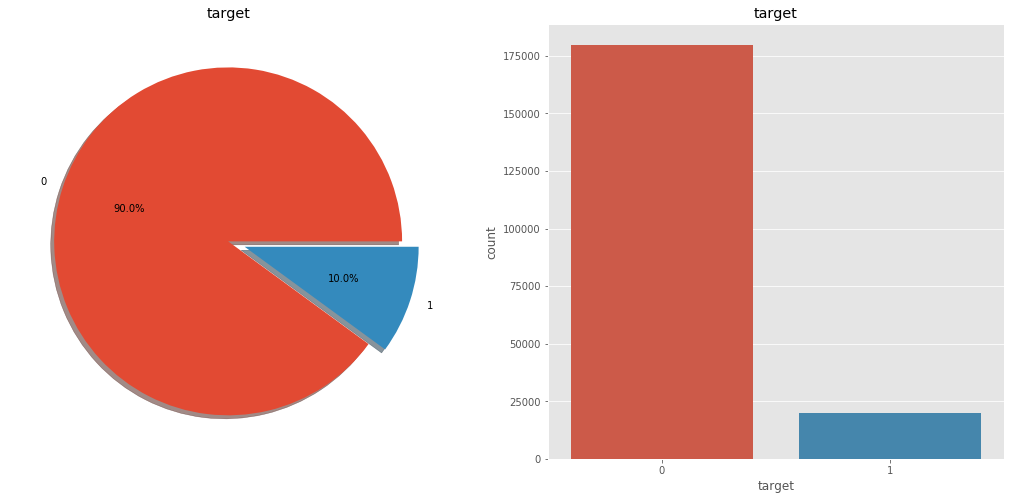

In [48]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('target')
ax[0].set_ylabel('')
sns.countplot('target',data=train,ax=ax[1])
ax[1].set_title('target')
plt.show()

<a id="424"></a> 
## 4-2-4 hist
If you check histogram for all feature, you will find that most of them are so similar

Distributions of first 28 columns


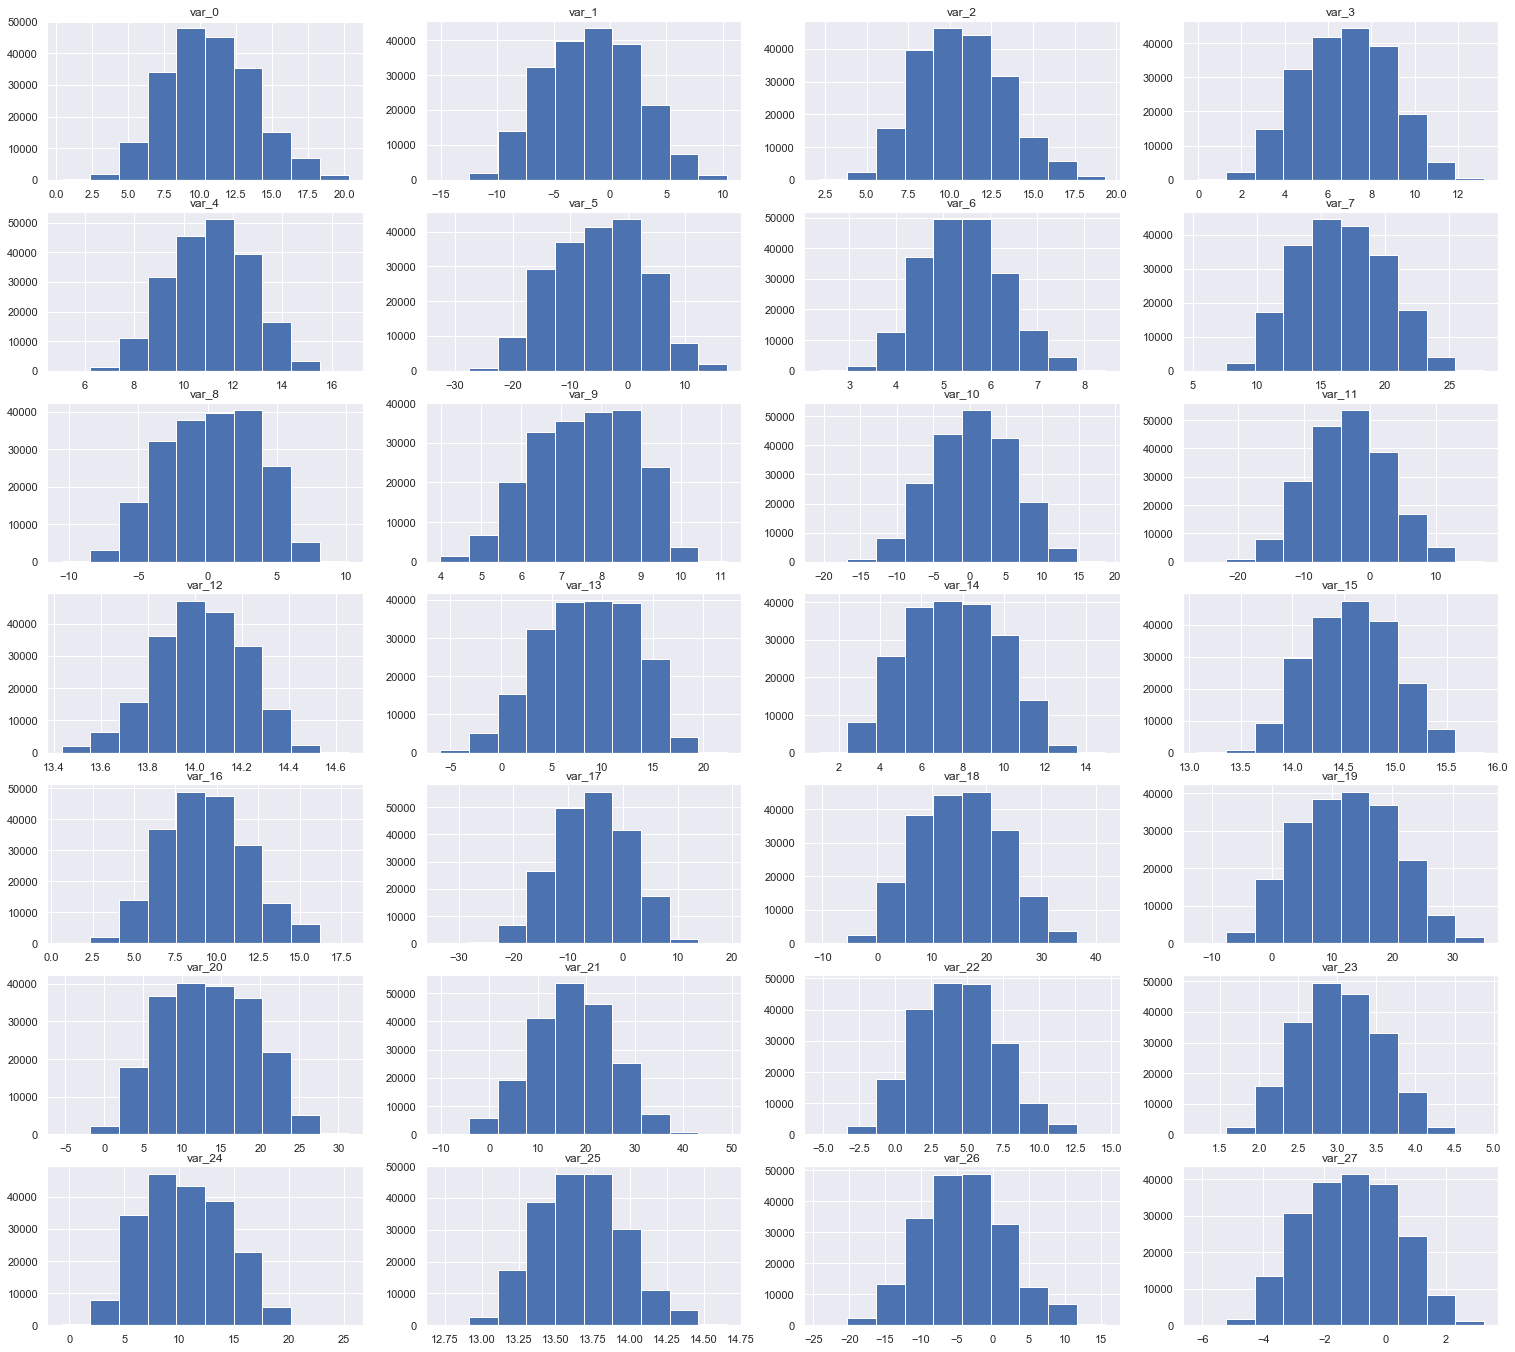

In [78]:
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(train[col])
    plt.title(col)

<a id="426"></a> 
## 4-2-6 violinplot

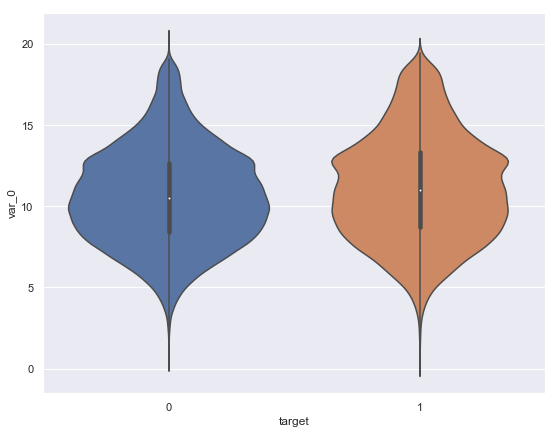

In [57]:
sns.violinplot(data=train,x="target", y="var_0")

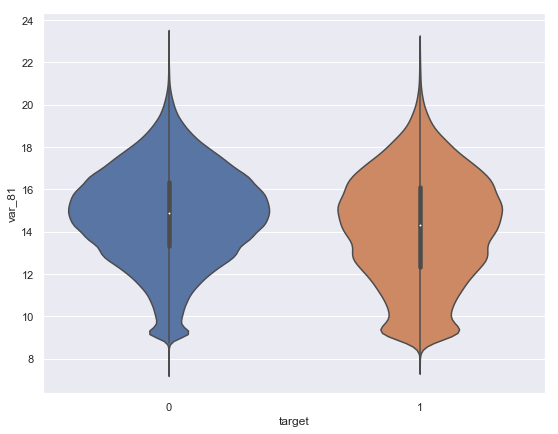

In [58]:
sns.violinplot(data=train,x="target", y="var_50")

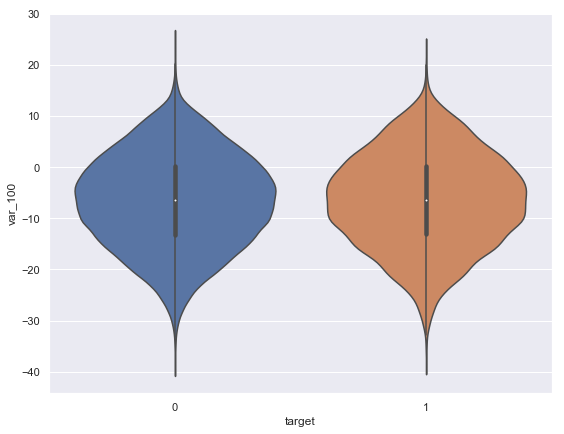

In [59]:
sns.violinplot(data=train,x="target", y="var_100")

 <a id="43"></a> <br>
## 4-3 Data Preprocessing

 <a id="431"></a> <br>
## 4-3-1 Check missing data for test & train

In [12]:
# we have no missing values in train
train.isnull().any().any()

False

In [13]:
# we have no missing values in test
test.isnull().any().any()

False

 <a id="432"></a> <br>
## 4-3-2 Binary Classification

In [65]:
train['target'].unique()

array([0, 1], dtype=uint64)

 <a id="433"></a> <br>
## 4-3-3 Is data set imbalance?

A large part of the data is unbalanced, but **how can we  solve it?**

In [66]:
train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [75]:
def check_balance(df,target):
    check=[]
    # for binary target
    print('size of data is:',df.shape[0] )
    for i in [0,1]:
        print('for target',str(i), ": ", df[target].value_counts()[i]/df.shape[0]*100,'%')
    

1. **Imbalanced dataset** is relevant primarily in the context of supervised machine learning involving two or more classes. 

1. **Imbalance** means that the number of data points available for different the classes is different


In [76]:
check_balance(train,'target')

size of data is: 200000
for target 0 :  89.95100000000001 %
for target 1 :  10.049 %


Remark : target is binary and has some disbalance: 10% of samples belong to 1 class

## 4-3-4 skewness and kurtosis

In [77]:
#skewness and kurtosis
print("Skewness: %f" % train['target'].skew())
print("Kurtosis: %f" % train['target'].kurt())

Skewness: 2.657642
Kurtosis: 5.063112


Let's have a look at correlations now!

In [ ]:
corrs = train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

We can see that correlations between features are so weak and the most correlated feature with target has correlation of 0.08. So we have no highly correlated features which we could drop, on the other hand we could drop some columns with have little correlation with the target.

 <a id="5"></a> <br>
# 5- Machine Learning Explainability for Santander
In this section, I want to try extract **insights** from models with the help of this excellent [**Course**](https://www.kaggle.com/learn/machine-learning-explainability) in Kaggle.
The Goal behind of ML Explainability for Santander is:
1. All features are senseless named.(var_1, var2,...) but certainly the importance of each one is different!
1. Extract insights from models.
1. Find the most important feature in models.
1. Affect of each feature on the model's predictions.

As you can see from the above, we will refer to three important and practical concepts in this section :
- Permutation importance
- Partial Plots
- SHAP Values

 <a id="51"></a> <br>
## 5-1 Permutation Importance
 
 <img src="https://i.imgur.com/h17tMUU.png">
 
 In this section we will answer following question:
 1. What features have the biggest impact on predictions?
 1. how to extract insights from models?

### Prepare our data for our model

In [16]:
cols=["target","ID_code"]
X = train.drop(cols,axis=1)
y = train["target"]


In [17]:
X_test  = test.drop("ID_code",axis=1)

### Create  a sample model to calculate which feature are more important.

In [18]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rfc_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

 <a id="52"></a> <br>
## 5-2 How to calculate and show importances?

### Here is how to calculate and show importances with the [eli5](https://eli5.readthedocs.io/en/latest/) library:

In [100]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)

Using TensorFlow backend.


In [101]:
eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=150)

Weight,Feature
0.0003 ± 0.0004,var_81
0.0003 ± 0.0001,var_94
0.0003 ± 0.0001,var_6
0.0002 ± 0.0002,var_22
0.0002 ± 0.0002,var_76
0.0002 ± 0.0002,var_34
0.0001 ± 0.0002,var_53
0.0001 ± 0.0001,var_93
0.0001 ± 0.0001,var_193
0.0001 ± 0.0002,var_12


<a id="53"></a> <br>
## 5-3 What can be inferred from the above?
1. As you move down the top of the graph, the importance of the feature decreases.
1. The features that are shown in green indicate that they have a positive impact on our prediction
1. The features that are shown in white indicate that they have no effect on our prediction
1. The features shown in red indicate that they have a negative impact on our prediction
1.  The most important feature was **Var_81**.

<a id="54"></a> <br>
## 5-4 Partial Dependence Plots
While **feature importance** shows what **variables** most affect predictions, **partial dependence** plots show how a feature affects predictions.
[partial-plots](https://www.kaggle.com/dansbecker/partial-plots)

In [103]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

For the sake of explanation, I use a Decision Tree which you can see below.

In [104]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]

In [105]:
from sklearn import tree
import graphviz
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=features)

In [106]:
graphviz.Source(tree_graph)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

As guidance to read the tree:

1. Leaves with children show their splitting criterion on the top
1. The pair of values at the bottom show the count of True values and False values for the target respectively, of data points in that node of the tree.
><font color="red"><b>Note: </b></font>
Yes **Var_81** are more effective on our model.

<a id="55"></a> <br>
## 5-5  Partial Dependence Plot
In this section, we see the impact of the main variables discovered in the previous sections by using the [pdpbox](https://pdpbox.readthedocs.io/en/latest/).

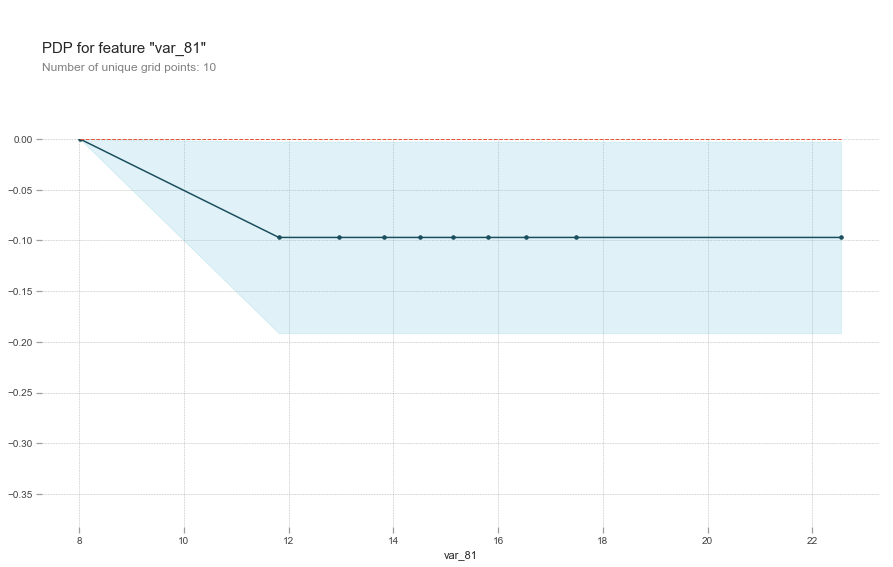

In [109]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_81')

# plot it
pdp.pdp_plot(pdp_goals, 'var_81')
plt.show()

<a id="56"></a> <br>
## 5-6 Chart analysis
1. The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
1. A blue shaded area indicates level of confidence

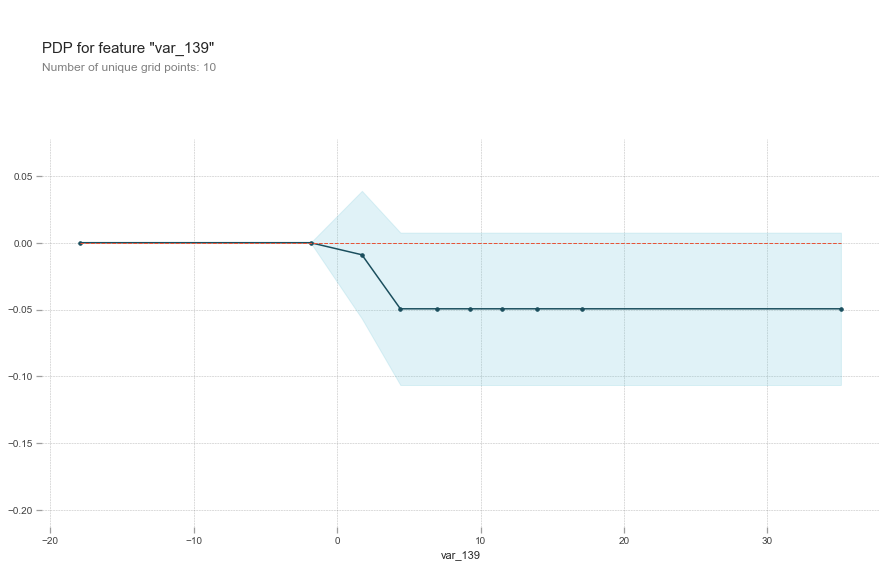

In [118]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_139')

# plot it
pdp.pdp_plot(pdp_goals, 'var_139')
plt.show()

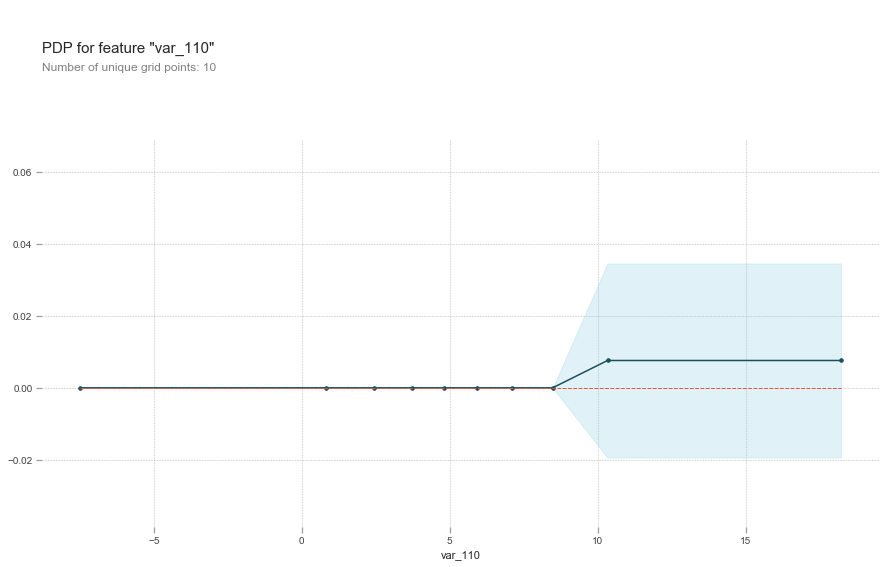

In [112]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_110')

# plot it
pdp.pdp_plot(pdp_goals, 'var_110')
plt.show()

 <a id="6"></a> <br>
# 6- Model Development
So far, we have used two  models, and at this point we add another model and we'll be expanding it soon.

It's important to remember that we need to avoid the Overfittening of our applicable models :

<img src="https://cdn-images-1.medium.com/max/1600/1*vuZxFMi5fODz2OEcpG-S1g.png" width=600>

In this section we will use following model:
1. lightgbm
1. RandomForestClassifier
1. DecisionTreeClassifier
1. CatBoostClassifier

## 6-1 lightgbm

In [20]:
# params is based on following kernel https://www.kaggle.com/brandenkmurray/nothing-works
params1 = {'objective' : "binary", 
               'boost':"gbdt",
               'metric':"auc",
               'boost_from_average':"false",
               'num_threads':8,
               'learning_rate' : 0.01,
               'num_leaves' : 13,
               'max_depth':-1,
               'tree_learner' : "serial",
               'feature_fraction' : 0.05,
               'bagging_freq' : 5,
               'bagging_fraction' : 0.4,
               'min_data_in_leaf' : 80,
               'min_sum_hessian_in_leaf' : 10.0,
               'verbosity' : 1}

In [19]:
%%time
y_pred_lgb = np.zeros(len(X_test))
num_round = 1000000
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(params1,train_data,num_round,#change 20 to 2000
                    valid_sets = [train_data, valid_data],verbose_eval=1000,early_stopping_rounds = 3500)##change 10 to 200
            
    y_pred_lgb += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)/5

Fold 0 started at Sat Nov 16 12:29:04 2019
Training until validation scores don't improve for 3500 rounds
[1000]	training's auc: 0.901253	valid_1's auc: 0.878517
[2000]	training's auc: 0.913832	valid_1's auc: 0.887269
[3000]	training's auc: 0.921987	valid_1's auc: 0.891626
[4000]	training's auc: 0.928122	valid_1's auc: 0.894103
[5000]	training's auc: 0.933228	valid_1's auc: 0.89534
[6000]	training's auc: 0.937804	valid_1's auc: 0.89587
[7000]	training's auc: 0.941946	valid_1's auc: 0.896424
[8000]	training's auc: 0.945795	valid_1's auc: 0.896424
[9000]	training's auc: 0.949434	valid_1's auc: 0.896426
[10000]	training's auc: 0.952996	valid_1's auc: 0.896493
[11000]	training's auc: 0.956271	valid_1's auc: 0.896529
[12000]	training's auc: 0.959457	valid_1's auc: 0.896511
[13000]	training's auc: 0.962405	valid_1's auc: 0.896332
[14000]	training's auc: 0.965332	valid_1's auc: 0.896246
Early stopping, best iteration is:
[11318]	training's auc: 0.957332	valid_1's auc: 0.896572
Fold 1 started 

KeyboardInterrupt: 

Trying to improve the parameters: 

In [21]:
params2 = {'learning_rate':0.06,
           'max_bin': 165,
           'max_depth': 5,
           'min_child_samples': 153,
           'min_child_weight': 0.1,
           'min_split_gain': 0.0018,
           'n_estimators': 41,
           'num_leaves': 6,
           'reg_alpha': 2.1,
           'reg_lambda': 2.54,
           'objective': "binary",
           'n_jobs': -1}

In [22]:
%%time
y_pred_lgb = np.zeros(len(X_test))
num_round = 1000000
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(params2,train_data,num_round,#change 20 to 2000
                    valid_sets = [train_data, valid_data],verbose_eval=1000,early_stopping_rounds = 3500)##change 10 to 200
            
    y_pred_lgb += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)/5

Fold 0 started at Sat Nov 16 12:59:42 2019
Training until validation scores don't improve for 3500 rounds
Did not meet early stopping. Best iteration is:
[41]	training's binary_logloss: 0.297148	valid_1's binary_logloss: 0.299723
Fold 1 started at Sat Nov 16 12:59:47 2019
Training until validation scores don't improve for 3500 rounds
Did not meet early stopping. Best iteration is:
[41]	training's binary_logloss: 0.297543	valid_1's binary_logloss: 0.298409
Fold 2 started at Sat Nov 16 12:59:51 2019
Training until validation scores don't improve for 3500 rounds
Did not meet early stopping. Best iteration is:
[41]	training's binary_logloss: 0.297188	valid_1's binary_logloss: 0.29923
Fold 3 started at Sat Nov 16 12:59:56 2019
Training until validation scores don't improve for 3500 rounds
Did not meet early stopping. Best iteration is:
[41]	training's binary_logloss: 0.297253	valid_1's binary_logloss: 0.299302
Fold 4 started at Sat Nov 16 13:00:01 2019
Training until validation scores don't

 <a id="62"></a> <br>
## 6-2 RandomForestClassifier

In [ ]:
y_pred_rfc = rfc_model.predict(X_test)

 <a id="63"></a> <br>
## 6-3 DecisionTreeClassifier

In [ ]:
y_pred_tree = tree_model.predict(X_test)

 <a id="64"></a> <br>
## 6-4 CatBoostClassifier

In [ ]:
train_pool = Pool(train_X,train_y)
cat_model = CatBoostClassifier(
                               iterations=3000,# change 25 to 3000 to get best performance 
                               learning_rate=0.03,
                               objective="Logloss",
                               eval_metric='AUC',
                              )
cat_model.fit(train_X,train_y,silent=True)
y_pred_cat = cat_model.predict(X_test)

Now you can change your model and submit the results of other models.

In [ ]:
submission_rfc = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_rfc
    })
submission_rfc.to_csv('submission_rfc.csv', index=False)

In [ ]:
submission_tree = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_tree
    })
submission_tree.to_csv('submission_tree.csv', index=False)

In [ ]:
submission_cat = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_cat
    })
submission_cat.to_csv('submission_cat.csv', index=False)

In [23]:
# good for submit
submission_lgb = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_lgb
    })
submission_lgb.to_csv('submission_lgb.csv', index=False)

NameError: name 'y_pred_lgb' is not defined

 <a id="65"></a> <br>
## 6-5 Funny Combine 

In [ ]:
submission_rfc_cat = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": (y_pred_rfc +y_pred_cat)/2
    })
submission_rfc_cat.to_csv('submission_rfc_cat.csv', index=False)

In [ ]:
submission_lgb_cat = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": (y_pred_lgb +y_pred_cat)/2
    })
submission_lgb_cat.to_csv('submission_lgb_cat.csv', index=False)

In [ ]:
submission_rfc_lgb = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": (y_pred_rfc +y_pred_lgb)/2
    })
submission_rfc_lgb.to_csv('submission_rfc_lgb.csv', index=False)

 <a id="7"></a> <br>
# 7- Summary
I hope you had fun reading this notebook. Please, if it gave you new ideas or if you learned something new about the data, consider upvoting, and let me know if you have succeeded implementing them.

Enjoy! ;)